In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import pytorch_lightning as pl
from torchvision import datasets,transforms
import torchvision


c:\Users\Tomislav\anaconda3\envs\pt_exp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch=32
learning_rate=0.01
epochs=11
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes=['female','male']

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
transform=transforms.Compose(
    [   transforms.Resize(60)
        ,transforms.ToTensor()
        ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
dataset=datasets.ImageFolder('data',transform=transform)
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True,)

In [4]:
train_size=int(0.8 * len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset, [train_size,test_size])

train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch,shuffle=True)


In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10, 2)
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        return x

In [18]:
from torchmetrics.functional import stat_scores
import torchmetrics

class LitNet(pl.LightningModule):
    def __init__(self,net):
        super().__init__()
        self.net = net
        self.accuracy = torchmetrics.Accuracy()
    
    def training_step(self,batch, batch_idx):
        x , y = batch
        y_pred = self.net(x)
        loss = F.cross_entropy(y_pred, y)
        self.log("train_loss", loss,on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.net(x)
        val_loss = F.cross_entropy(y_pred, y)
        self.log("val_loss", val_loss,on_epoch=True, prog_bar=True, logger=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.net(x)
        val_loss = F.cross_entropy(y_pred, y)
        self.accuracy(y_pred, y)
        self.log("test_loss", val_loss,on_epoch=True, prog_bar=True, logger=True)
    
    def test_epoch_end(self,outs):
        self.log('test_acc',self.accuracy)
    
    
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        pred = self.net(x)
        return pred
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer  

In [19]:
model = LitNet(Net())

In [20]:
trainer = pl.Trainer(max_epochs= 5)
trainer.fit(model = model,train_dataloaders = train_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Tomislav\anaconda3\envs\pt_exp\lib\site-packages\pytorch_lightning\trainer\trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Users\Tomislav\anaconda3\envs\pt_exp\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name     | Type     | Params
--------------------------------------
0 | net      | Net      | 290 K 
1 | accuracy | Accuracy | 0     
--------------------------------------
290 K     Trainable params
0         Non-trainable params
290 K     Total params
1.162     Total estimated model param

Epoch 4: 100%|██████████| 289/289 [00:26<00:00, 10.89it/s, loss=0.203, v_num=4, train_loss_step=0.00956, train_loss_epoch=0.211]


In [21]:
trainer.test(model=model,dataloaders=test_loader)

c:\Users\Tomislav\anaconda3\envs\pt_exp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:487: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\Tomislav\anaconda3\envs\pt_exp\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 73/73 [00:02<00:00, 29.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9049891829490662
        test_loss           0.2340652495622635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2340652495622635, 'test_acc': 0.9049891829490662}]

In [7]:
import torch.optim as optim;

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=learning_rate)

In [8]:
for epoch in range(epochs):
    running_loss=0.0
    for i,(data,target) in enumerate(train_loader,0):
        inputs,labels=data.to(device),target.to(device)

        optimizer.zero_grad()

        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 100 == 0:    
            print('%d, %5d loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
print('Finished training')

1,   100 loss: 0.692
1,   200 loss: 0.690
2,   100 loss: 0.690
2,   200 loss: 0.691
3,   100 loss: 0.689
3,   200 loss: 0.688
4,   100 loss: 0.691
4,   200 loss: 0.685
5,   100 loss: 0.689
5,   200 loss: 0.691
6,   100 loss: 0.691
6,   200 loss: 0.687
7,   100 loss: 0.690
7,   200 loss: 0.687
8,   100 loss: 0.689
8,   200 loss: 0.690
9,   100 loss: 0.687
9,   200 loss: 0.691
10,   100 loss: 0.687
10,   200 loss: 0.691
11,   100 loss: 0.690
11,   200 loss: 0.689
Finished training


In [10]:
import pandas as pd
import numpy as np
correct = 0
total = 0
test_lab=[]
test_pred=[]
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data,target in test_loader:
        images, labels = data.to(device),target.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        test_lab+=list(labels.cpu())
        test_pred+=list(predicted.cpu())

        correct += (predicted == labels).sum().item()
        

print('Accuracy of the network : %d %%' % (
    100 * correct / total))
conf_matrix_nb = pd.crosstab(
        np.array(test_lab),
        np.array(test_pred),
        rownames=['Actual'],
        colnames=['Predicted']
    )

Accuracy of the network : 55 %


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

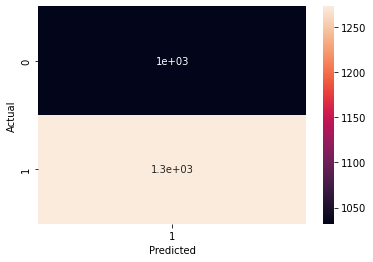

In [12]:
import seaborn as sns
sns.heatmap(conf_matrix_nb,annot=True)

In [13]:
conf_matrix_nb

Predicted,1
Actual,
0,1032
1,1273


In [203]:
transform=transforms.Compose(
    [   transforms.Resize((60,60))
        ,transforms.ToTensor()
        ,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

dataset=datasets.ImageFolder('D:\Custom made programs\Python\eyes_prediction_sex\\real_data',transform=transform)
dataloader=torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=2)

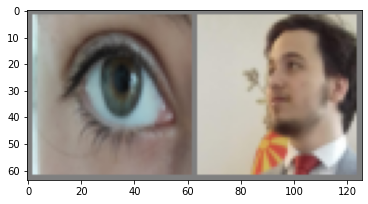

In [191]:
import matplotlib.pyplot as plt
import numpy as np
images, labels = next(iter(dataloader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

torch.Size([1, 3, 60, 60])


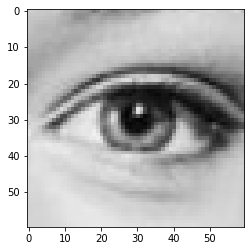

Predicted classes: female Actuall class: female


In [207]:


test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)
images,labels=next(iter(test_loader))
images=images.to(device)
labels=labels.to(device)
print(images.shape)
outputs = net(images)

#print(outputs)
_, predicted = torch.max(outputs.data, 1)
imshow(torchvision.utils.make_grid(images.cpu()))
print(f'Predicted classes: {classes[predicted[0]]} Actuall class: {classes[labels[0]]}')


male
100.00 %


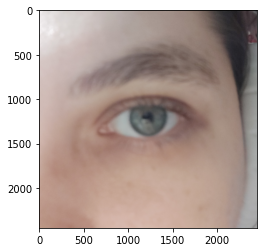

In [279]:
from PIL import Image

img=Image.open('D:\Custom made programs\Python\eyes_prediction_sex\\real_data\\female\\angela.jpg')
img_original=img
img=transform(img)

img=img.view(1,3,60,60).to(device)
#print(torch.)
output=net(img)
conf,predicted=torch.max(output.data,1)

plt.imshow(img_original)

print(classes[predicted.item()])
print(f'{F.softmax(output,dim=0).max().item()*100:.2f} %')
